# Location interpolation best methods

Try out many different methods to get the coordinates for our spatial data given an OT mapping to histo. Find out why regressors never have good performance on the unseen histo set. To start, work with the fused problem, since it encodes location better

In [38]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotnine as p9
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.metrics import r2_score
from sklearn.linear_model import RANSACRegressor
import umap
from scipy.stats import ks_2samp
from scipy.sparse import identity
from scipy.sparse.linalg import cg
from moscot.problems.cross_modality import TranslationProblem

#### Load the data

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/models/sampled_targets_fused"
adata_st = sc.read_h5ad(os.path.join(path, "adata_src.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_target.h5ad"))
adata_st.shape, adata_histo.shape

((50000, 50), (50156, 1536))

Since there was an error in my translate.py, i need to save the histo adata correctly now

In [5]:
adata_target = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/translation2/adata_histo.h5ad")
fractions = 4
perm_M = np.load("/p/project1/hai_fzj_bda/koenig8/ot/models/sampled_targets_fused/permutation_target.npy")
M = adata_target.shape[0]
step_M = int(np.ceil(M/fractions))
adata_target.obs["fraction"] = -1
adata_target.obs.iloc[perm_M, -1] = np.repeat(np.arange(fractions), step_M)[perm_M]
print( adata_target.shape)
adata_target.obs.head(4)

(50156, 1536)


image_id  patchsize  \
125130   100960256_881        256   
24074      100966096_5        256   
151609  100966092_1710        256   
33680    100960384_773        256   

                                               center_ccf  \
125130  {'x': 6567.833814364565, 'y': 3322.00540941353...   
24074   {'x': 9604.499635719421, 'y': 805.642665328999...   
151609  {'x': 9732.17623735755, 'y': 6951.811153739401...   
33680   {'x': 3435.630968019212, 'y': 4713.81672550880...   

                                              pixel_coord        distance  \
125130  {'center_x': 4200, 'center_y': 3300, 'x_min': ...  [159.71906896]   
24074   {'center_x': 3900, 'center_y': 750, 'x_min': 3...   [48.54096362]   
151609  {'center_x': 3450, 'center_y': 6450, 'x_min': ...   [78.94973124]   
33680   {'center_x': 1200, 'center_y': 3900, 'x_min': ...  [111.18285305]   

                                               nearest_ST  \
125130  {'x': 6.409781024556857, 'y': 3.31027145296862...   
24074   {'x': 9.556928457112535, 'y': 0.80539496274934...   
151609  {'x': 9.657205897606984, 'y': 6.93635284739502...   
33680   {'x': 3.325872107205797, 'y': 4.703618229293, ...   

              nearest_cell_id  target_atlas_plate  distance_new            x  \
125130    1019171906101600207                55.0    159.719069  6567.833814   
24074     1019171912101400816                85.0     48.540964  9604.499636   
151609  1018093344101620291-4                95.0     78.949731  9732.176237   
33680     1018143423100660291                27.0    111.182853  3435.630968   

                  y            z      x_st      y_st      z_st   image_nr  \
125130  3322.005409  4278.875327  6.409781  3.310271  4.298670  100960256   
24074    805.642665  4161.743470  9.556928  0.805395  4.171395  100966096   
151609  6951.811154  4103.102048  9.657206  6.936353  4.122429  100966092   
33680   4713.816726  2751.321985  3.325872  4.703618  2.736810  100960384   

          brain_area  group      slice  fraction  
125130            TH      6  100960256         0  
24074      Isocortex     17  100966096         0  
151609  white_matter     18  100966092         0  
33680      Isocortex     14  100960384         0

In [6]:
# Save adata_target again
adata_target.write_h5ad(os.path.join(path, "adata_target.h5ad"))
adata_histo = adata_target

These were the scores for location interpolation in my translate call. The IDWE shows that the location is better than random, but somehow the R2 from my regressor is quite bad:
```
Location regression R2 on test set: 0.8090225561693796 
Location regression R2 on translation -1.1948852180945393 

Coordinate interpolation score: 0.4023501945985908
```

### Try and understand how similar the embeddings are

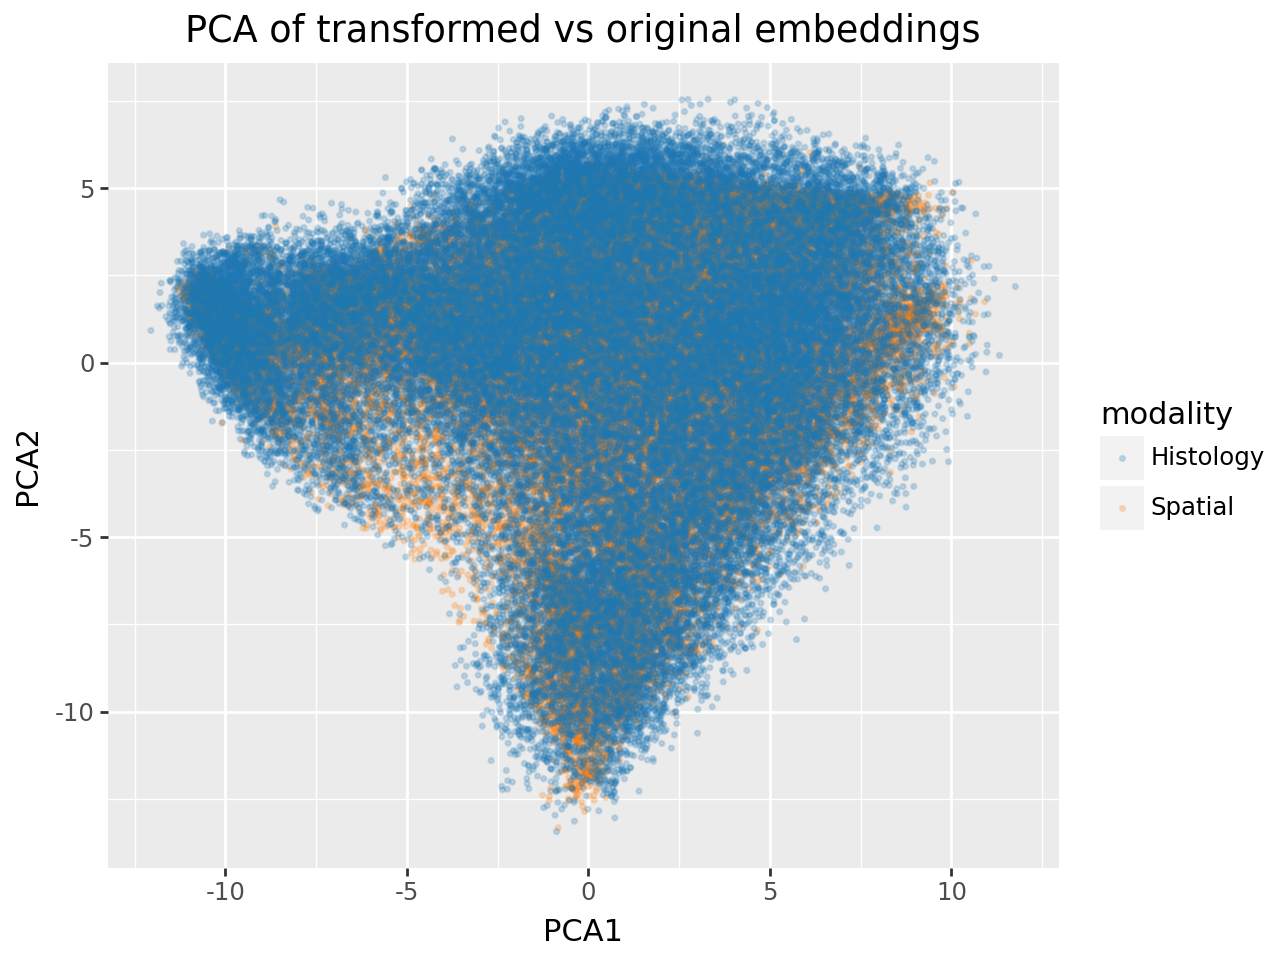

In [23]:
X = np.concatenate([adata_st.obsm["transformed"], adata_histo.obsm["uni_pca_95"]], axis=0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns = ["PCA1", "PCA2"]).assign(modality="Spatial")
X_pca.iloc[adata_st.shape[0]:, -1] = "Histology"

plot = (p9.ggplot(X_pca, p9.aes(x="PCA1", y = "PCA2", color = "modality")) +
        p9.geom_point(alpha=0.2, size = 0.5) +
        p9.ggtitle("PCA of transformed vs original embeddings") +
        p9.scale_color_manual(values=["#1f77b4", "#ff7f0e"])
       )
plot

### They overlap very well. Now lets see how good the original spatial annotations overlap using UMAP

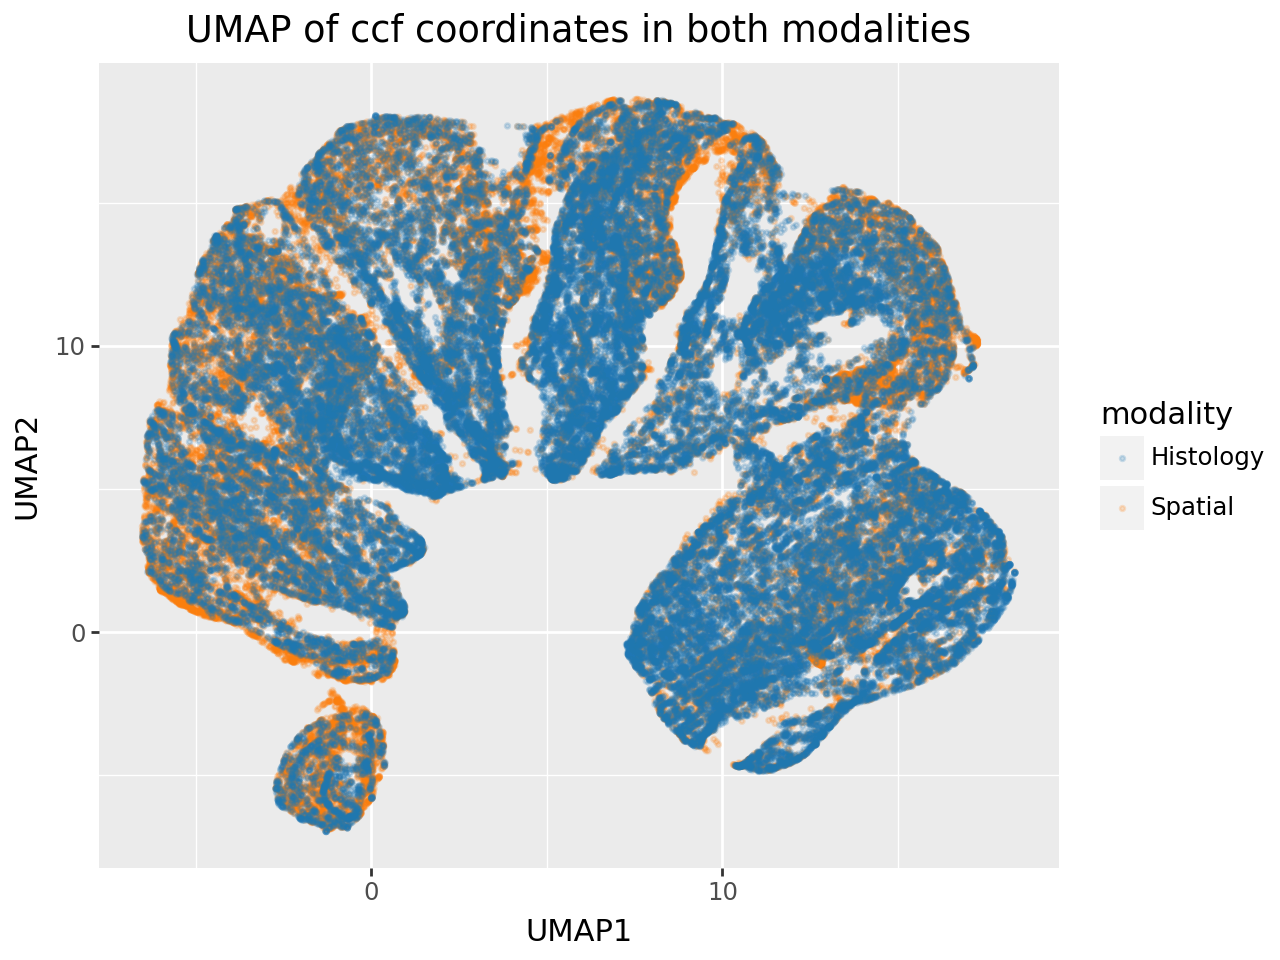

In [22]:
# Combine X and Y and create labels
X = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
Y = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
data = np.vstack([X, Y])
labels = np.array(['Spatial'] * X.shape[0] + ['Histology'] * Y.shape[0])

# Perform UMAP
dumap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = dumap.fit_transform(data)

# Create a DataFrame for visualization
df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df["modality"] = labels

# Plot using plotnine
plot = (
    p9.ggplot(df, p9.aes(x="UMAP1", y="UMAP2", color="modality")) +
    p9.geom_point(alpha=0.2, size = 0.5) +
    p9.ggtitle("UMAP of ccf coordinates in both modalities") +
    p9.scale_color_manual(values=["#1f77b4", "#ff7f0e"])
)

plot

==> Also does not seem to visually differ a lot
The coordinates seem to have at least the same structure between the modalities. But let's see if the translation retains location information

In [ ]:
X = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
labels = np.vstack([X, X])

# Perform UMAP
dumap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_og = dumap.fit_transform(adata_st.obsm["pca_embedding"])
dumap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_trans = dumap.fit_transform(adata_st.obsm["transformed"])

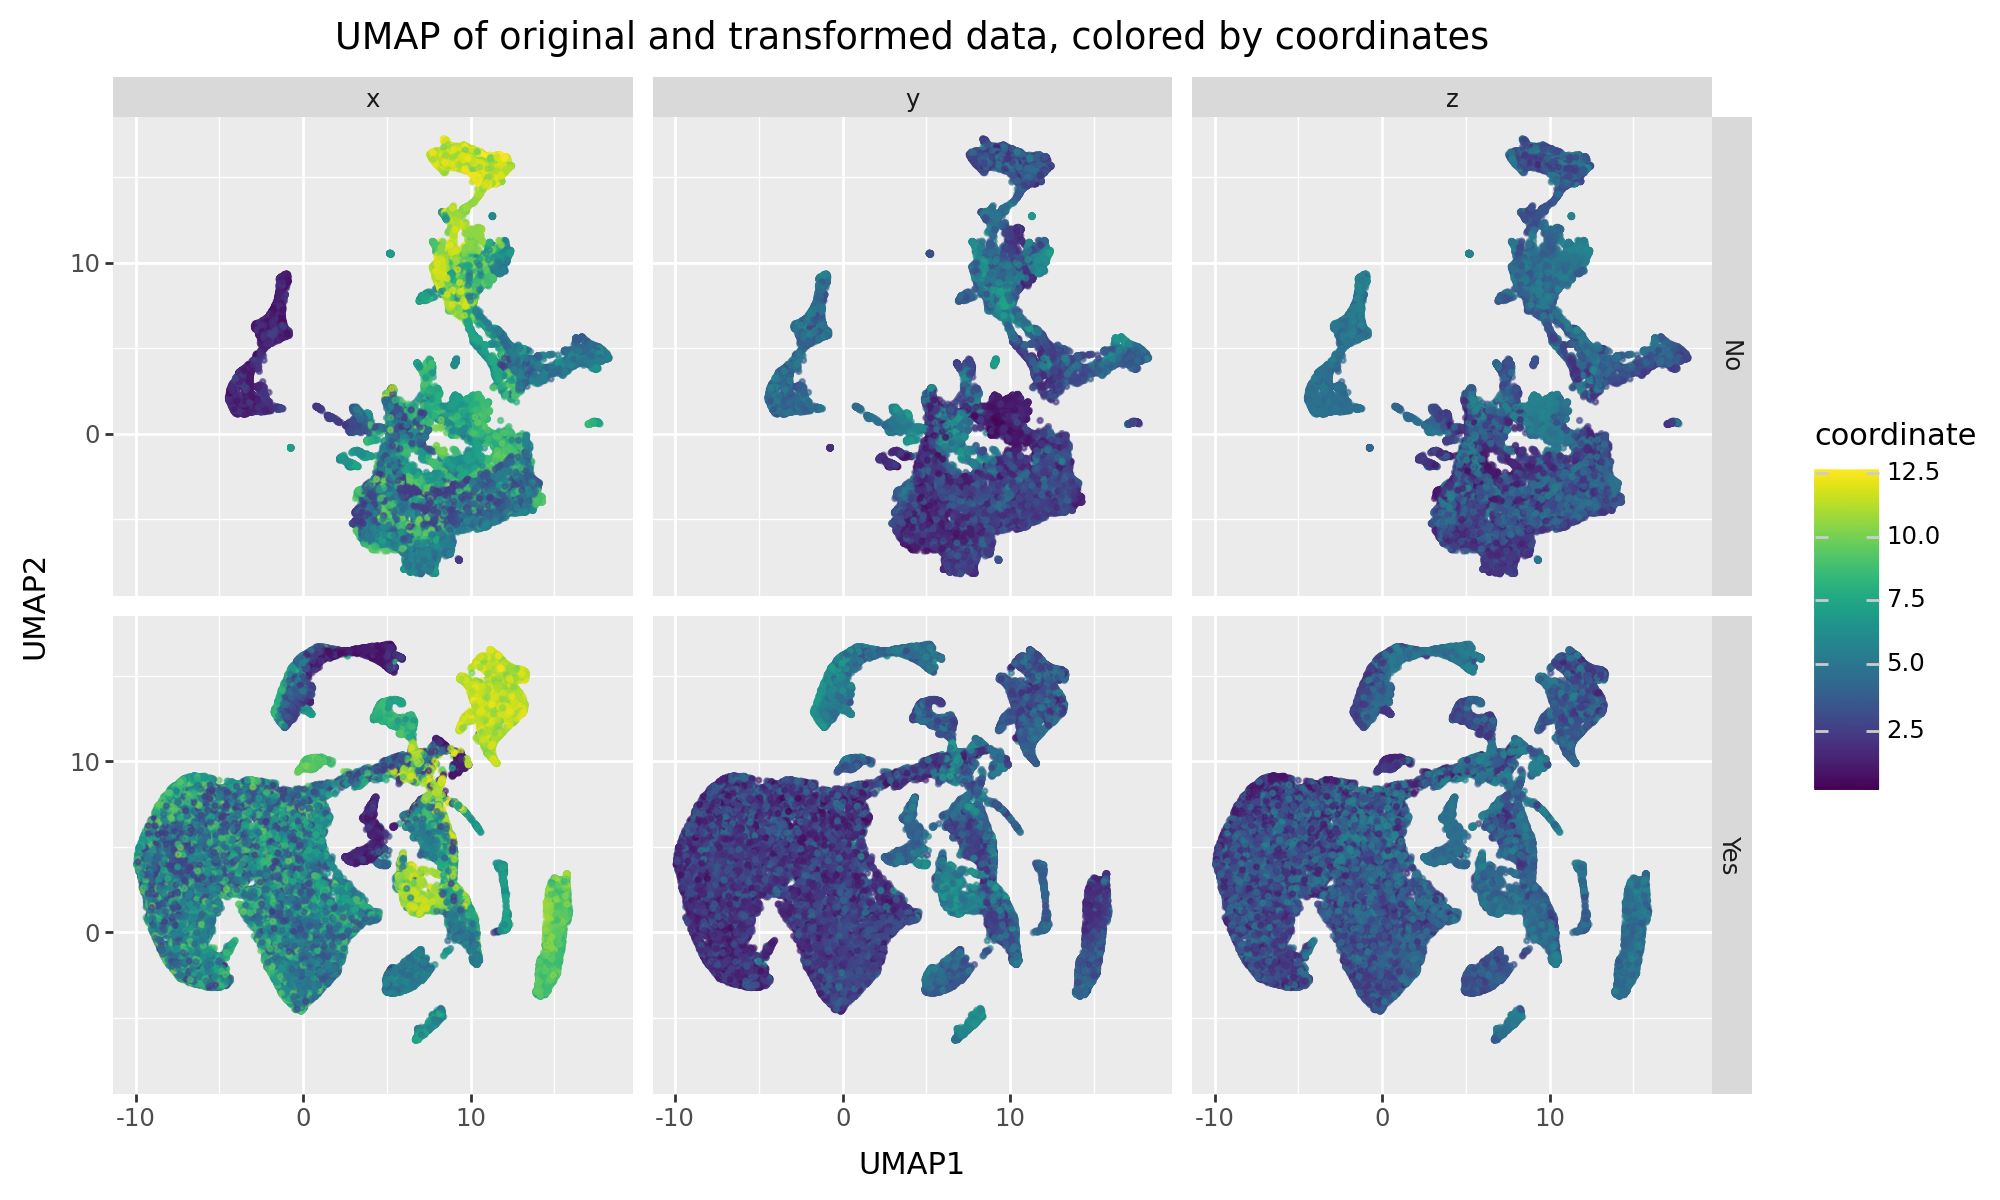

In [15]:
# Create a DataFrame for visualization
df_og = pd.DataFrame(embedding_og, columns=["UMAP1", "UMAP2"])
df_trans = pd.DataFrame(embedding_trans, columns=["UMAP1", "UMAP2"])
df = pd.concat([df_og.assign(transformed = "No"), df_trans.assign(transformed = "Yes")], ignore_index = True)
df[["x", "y", "z"]] = labels
df = df.melt(id_vars = ["UMAP1", "UMAP2", "transformed"],value_vars = ["x", "y", "z"], var_name = "axis", value_name = "coordinate")

# Plot using plotnine
plot = (
    p9.ggplot(df, p9.aes(x="UMAP1", y="UMAP2", color="coordinate")) +
    p9.geom_point(alpha=0.6, size = 0.5) +
    p9.facet_grid("transformed", "axis") +
    p9.ggtitle("UMAP of original and transformed data, colored by coordinates") +
    p9.theme(figure_size= (10, 6))
)

plot

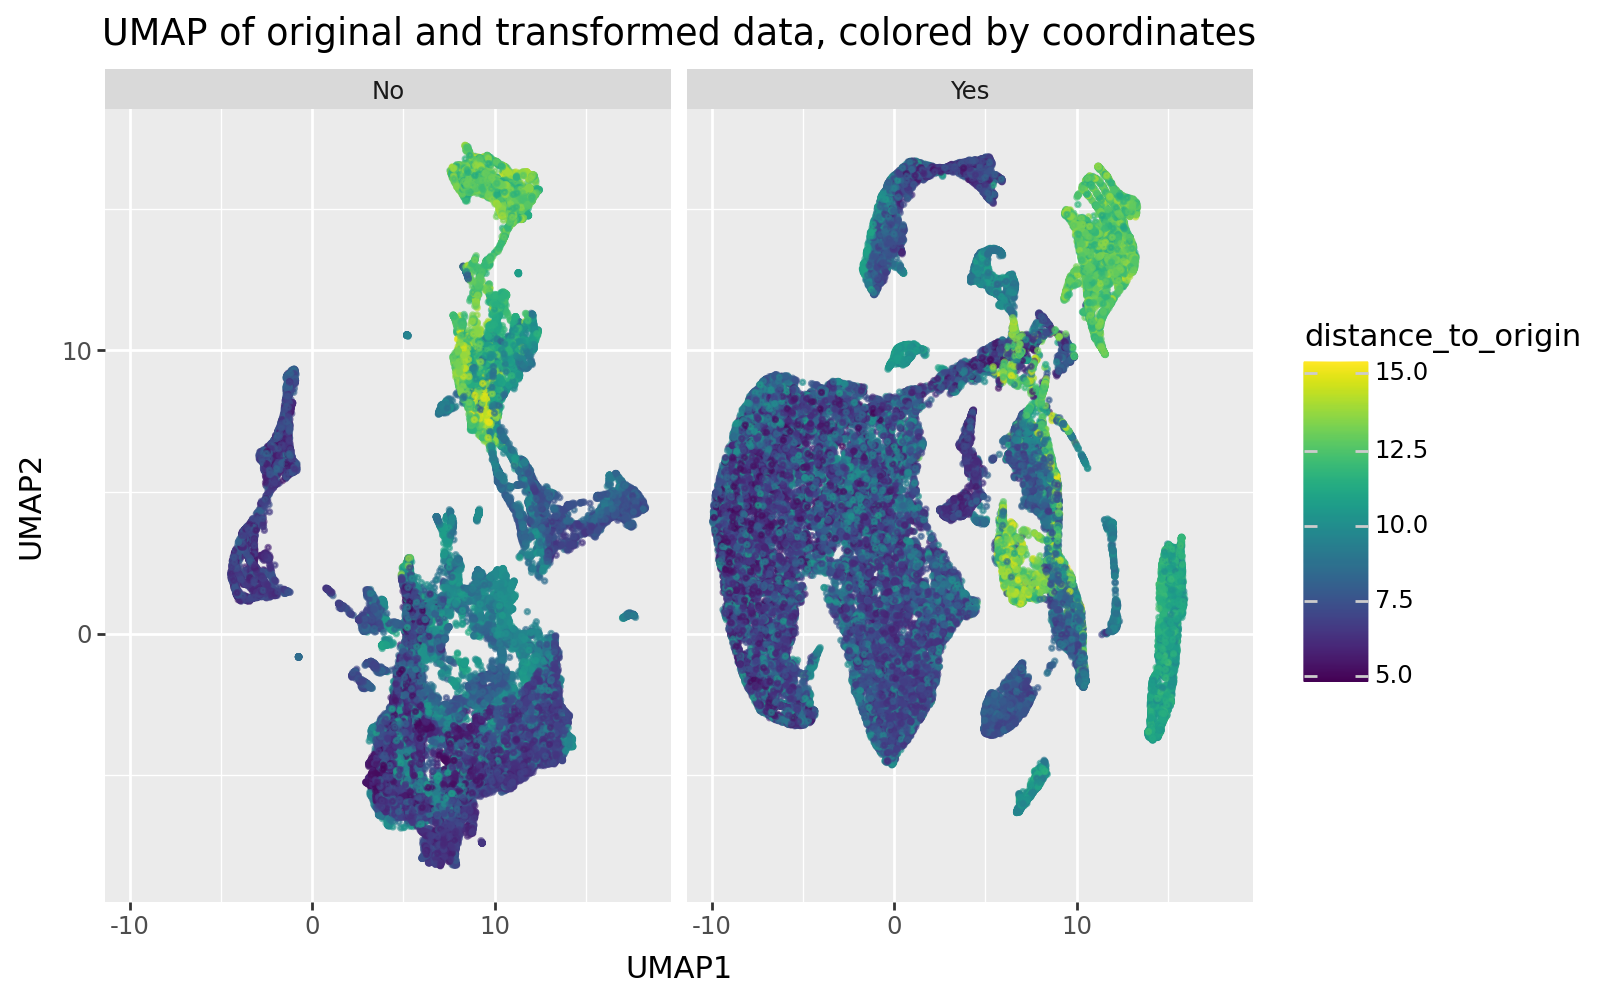

In [16]:
df = pd.concat([df_og.assign(transformed = "No"), df_trans.assign(transformed = "Yes")], ignore_index = True)
df["distance_to_origin"] = np.sqrt(np.sum(np.square(labels), axis = 1))

plot = (
    p9.ggplot(df, p9.aes(x="UMAP1", y="UMAP2", color="distance_to_origin")) +
    p9.geom_point(alpha=0.6, size = 0.5) +
    p9.facet_wrap("~ transformed") +
    p9.ggtitle("UMAP of original and transformed data, colored by coordinates") +
    p9.theme(figure_size= (8,5))
)

plot

==> this also looks promising, seems as if the translation problem does not cause any loss of spatial information that was already persent in the st data

In [3]:
X_coords = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
Y_coords = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
X = adata_st.obsm["transformed"]
Y = adata_histo.obsm["uni_pca_95"]
data = np.vstack([X, Y])
labels = np.array(['Spatial'] * X.shape[0] + ['Histology'] * Y.shape[0])
coords = np.vstack([X_coords, Y_coords])

# Perform UMAP
dumap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = dumap.fit_transform(data)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


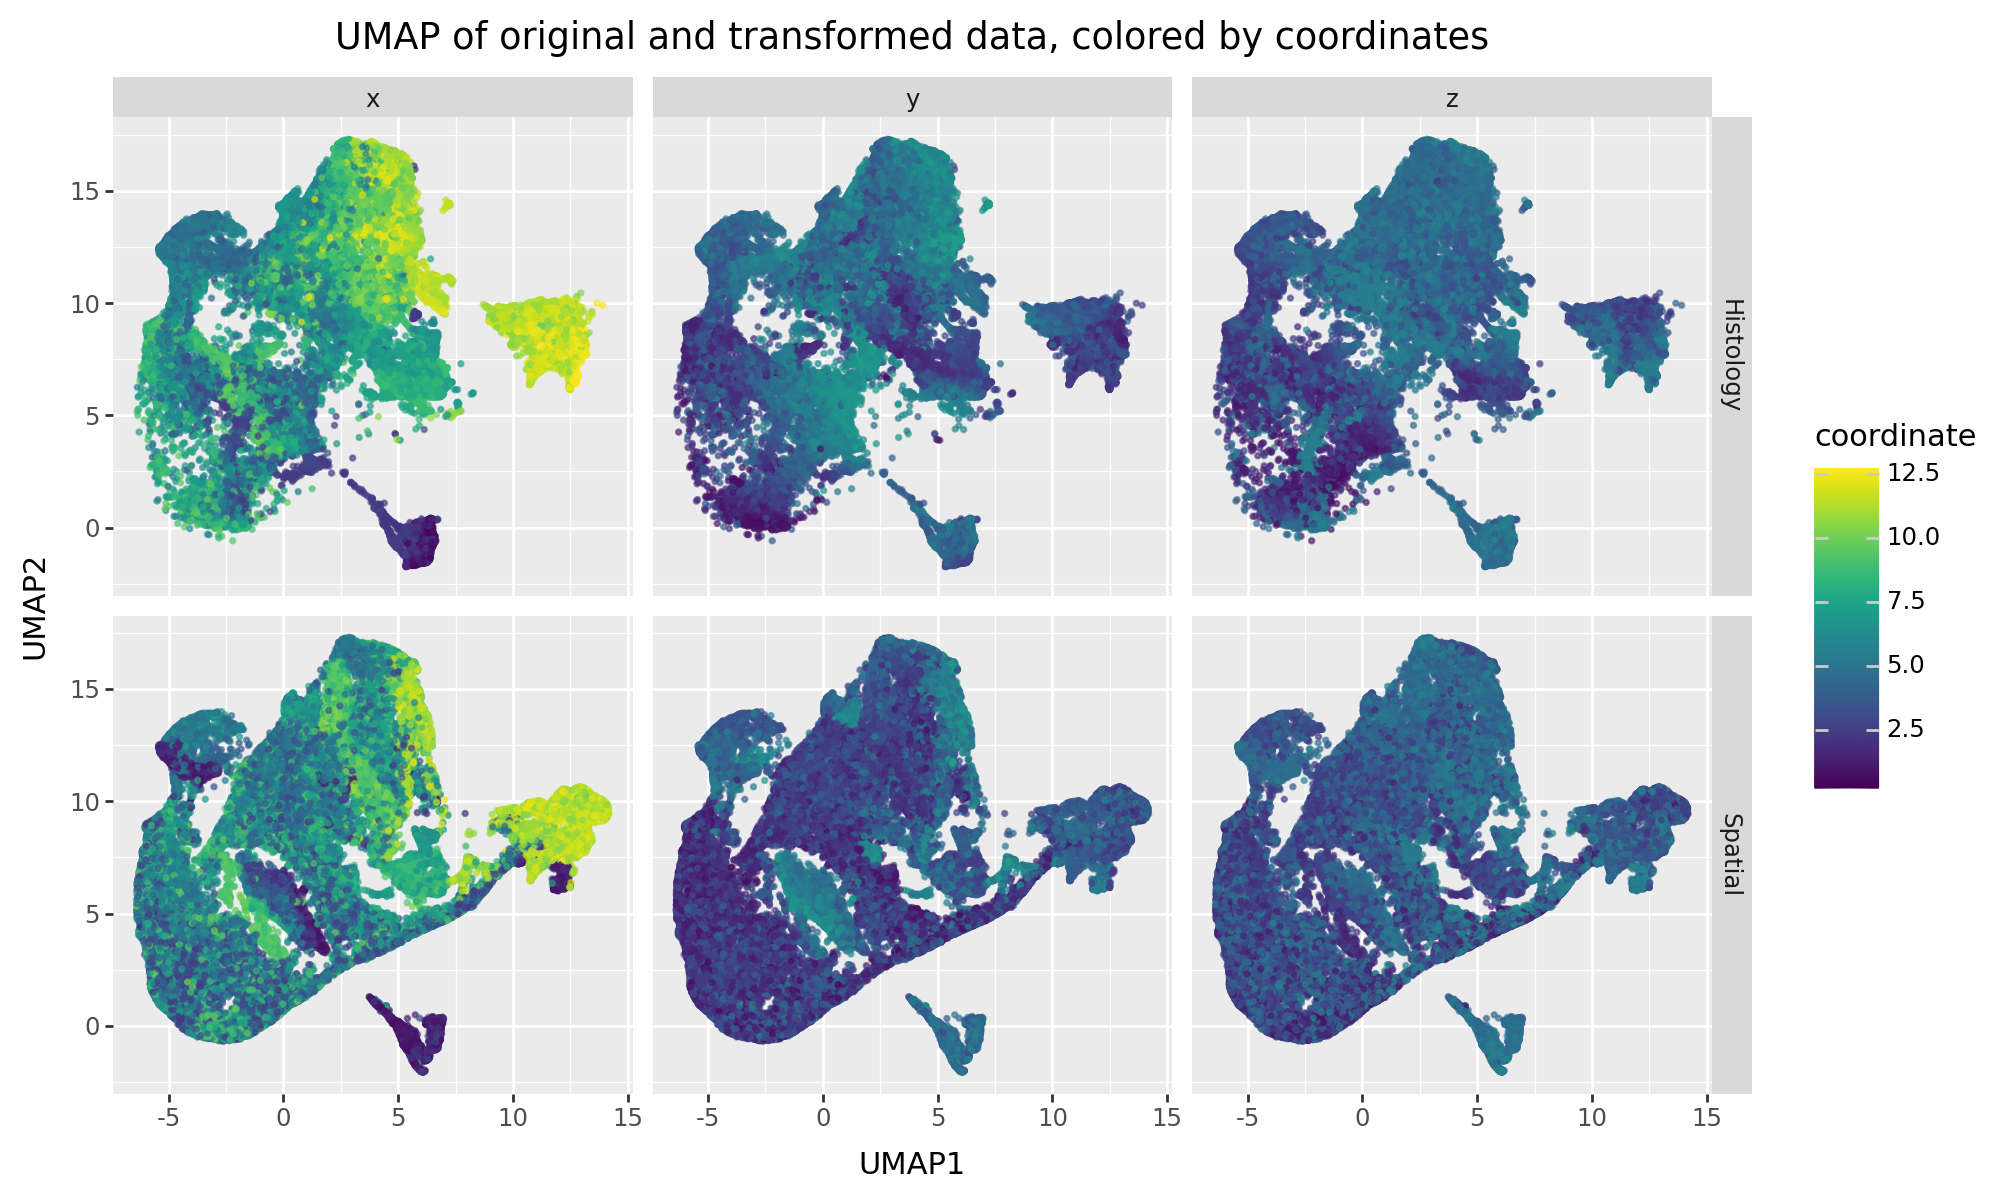

In [7]:
df_plot = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"]).assign(modality = labels)
df_plot[["x", "y", "z"]] = coords
df_plot = df_plot.melt(id_vars = ["UMAP1", "UMAP2", "modality"],value_vars = ["x", "y", "z"], var_name = "axis", value_name = "coordinate")

# Plot using plotnine
plot = (
    p9.ggplot(df_plot, p9.aes(x="UMAP1", y="UMAP2", color="coordinate")) +
    p9.geom_point(alpha=0.6, size = 0.5) +
    p9.facet_grid("modality", "axis") +
    p9.ggtitle("UMAP of original and transformed data, colored by coordinates") +
    p9.theme(figure_size= (10, 6))
)

plot

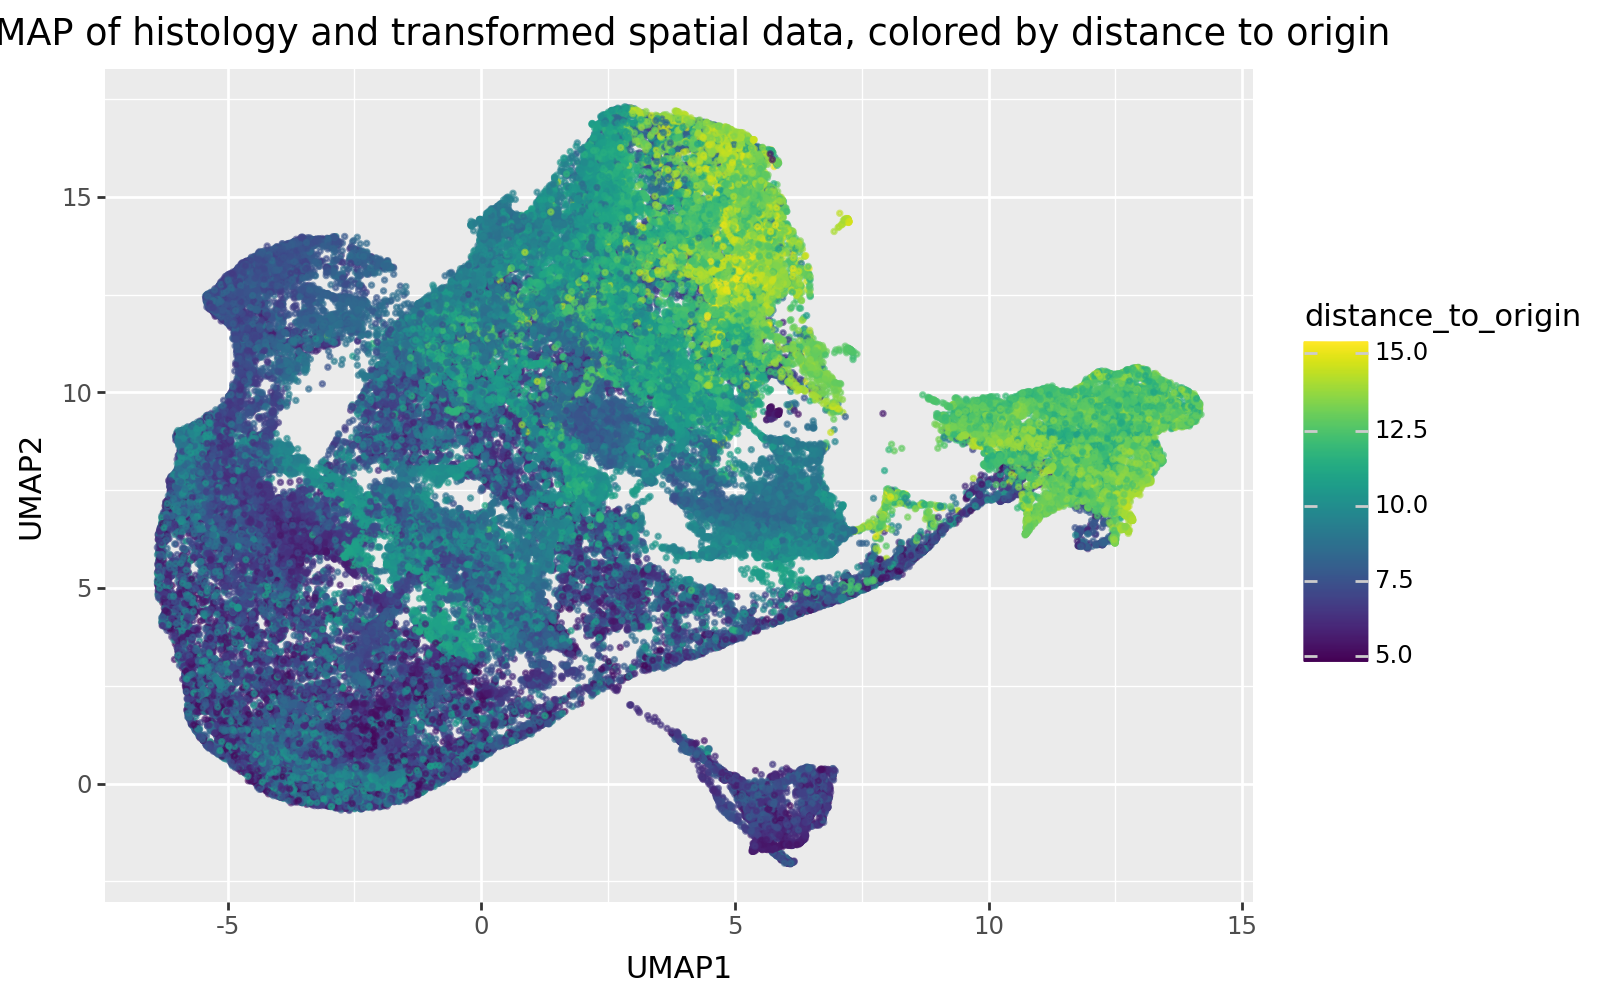

In [8]:
df_plot = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"]).assign(modality = labels)
df_plot["distance_to_origin"] = np.sqrt(np.sum(np.square(coords), axis = 1))

plot = (
    p9.ggplot(df_plot, p9.aes(x="UMAP1", y="UMAP2", color="distance_to_origin")) +
    p9.geom_point(alpha=0.6, size = 0.5) +
    p9.ggtitle("UMAP of histology and transformed spatial data, colored by distance to origin") +
    p9.theme(figure_size= (8,5))
)

plot

==> This looks super promising, the coordinate information shows clear clusters in the mixed modality embedding. 

### Use the Kolmogorov-Smirnov test to see if they statistically follow the same distribution

In [3]:
# For coordinates
X = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
Y = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()

p_values = [ks_2samp(X[:, i], Y[:, i])[1] for i in range(3)]
p_values

[np.float64(0.0), np.float64(0.0), np.float64(1.2674262211342607e-23)]

==> Not identical

In [27]:
X = adata_st.obsm["transformed"]
Y = adata_histo.obsm["uni_pca_95"]
p_values = [ks_2samp(X[:, i], Y[:, i])[1] for i in range(368)]
print("Percentage of features with p > 0.05:", np.mean(np.array(p_values) > 0.05))

Percentage of features with p > 0.05: 0.0


==> Also not identical

Statistically, the two modalities are still not from the same distribution

# Use label propagation in graphs

In [54]:
def plot_residuals(y_true, y_pred):
    residuals = np.sqrt(np.sum(np.square(y_true - y_pred), axis = 1))
    residuals = pd.DataFrame(residuals, columns = ("residuals",))
    # Plot density
    plot = (
        p9.ggplot(residuals, p9.aes(x="residuals")) +
        p9.geom_histogram(bins=30, fill = "red")  +# Transparency for overlap
        p9.ggtitle("Residual distribution") +
        p9.theme(figure_size=(5,2))
    )  
    
    return plot

In [18]:
histo_embeddings = adata_histo.obsm["uni_pca_95"]
spatial_embeddings = adata_st.obsm["transformed"]
histo_coordinates = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
spatial_coordinates = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()

# Combine both embeddings
all_embeddings = np.vstack([histo_embeddings, spatial_embeddings])

# Prepare labels
num_histo = histo_embeddings.shape[0]
num_spatial = spatial_embeddings.shape[0]
y_labels = np.full((num_histo + num_spatial, 3), -1)  # NaN for unknown labels
y_labels[:num_histo] = histo_coordinates  # Assign known coordinates

# Label spreading model
predictions = np.ones((num_spatial, 3))
for i in range(3):
    label_prop = LabelSpreading(kernel="knn", alpha=0.9, n_neighbors=15, max_iter = 50)
    label_prop.fit(all_embeddings, y_labels[:, i])
    predictions[:, i] = label_prop.transduction_[num_histo:]
    
# Get predicted coordinates for spatial embeddings
r2_score(spatial_coordinates, predictions)

-0.487582174920886

In [19]:
predictions

array([[ 9.,  1.,  2.],
       [ 6.,  2.,  3.],
       [ 9.,  1.,  2.],
       ...,
       [11.,  4.,  2.],
       [ 9.,  1.,  2.],
       [ 9.,  1.,  2.]])

==> This expects classes, not continuous variables
## Try solving the laplacian smoothing equation
$F^* = (I - \alpha L)^{-1}Y$

In [ ]:
histo_embeddings = adata_histo.obsm["uni_pca_95"]
spatial_embeddings = adata_st.obsm["transformed"]
histo_coordinates = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
spatial_coordinates = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()

all_embeddings = np.vstack([histo_embeddings, spatial_embeddings])
num_histo = histo_embeddings.shape[0]
num_spatial = spatial_embeddings.shape[0]

# Construct kNN graph
W = kneighbors_graph(all_embeddings, n_neighbors=10, mode="connectivity")
W = 0.5 * (W + W.T)  # Ensure symmetry

# Compute graph Laplacian
D = np.diag(W.sum(axis=1).A1)  # Degree matrix
L = D - W  # Laplacian matrix

# Prepare known label matrix (NaNs for unknowns)
Y = np.full((num_histo + num_spatial, 3), np.nan)
Y[:num_histo] = histo_coordinates  # Assign known coordinates

# Solve (I - alpha * L) F = Y for F
alpha = 0.9  # Propagation strength
I = identity(L.shape[0])

# Function to solve for each coordinate separately
def propagate_labels(Y_col):
    mask = ~np.isnan(Y_col)  # Mask of known labels
    b = np.zeros_like(Y_col)
    b[mask] = Y_col[mask]  # Only retain known labels in the equation

    A = I - alpha * L  # (I - αL)
    F_col, _ = cg(A, b)  # Solve sparse linear system
    return F_col

# Solve for x and y coordinates separately
F_x = propagate_labels(Y[:, 0])
F_y = propagate_labels(Y[:, 1])
F_z = propagate_labels(Y[:, 2])

predicted_spatial_coordinates = np.column_stack([
    F_x[num_histo:], F_y[num_histo:], F_z[num_histo:]
])

r2_score(spatial_coordinates, predicted_spatial_coordinates)

# Use one-nn based propagation

R²: -0.40026063814412544


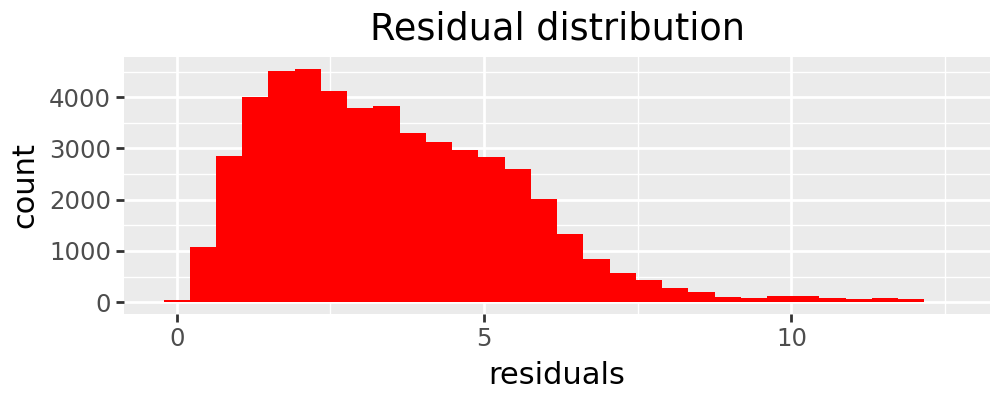

In [55]:
histo_coordinates = adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
spatial_coordinates = adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()

def one_nn_interpolation(
    translation, source_features, target_features, target_ad, emb_key = "uni_pca_95", rank = True
):
    # calculate the k nearest neighbors on the translation
    target_embedding = target_ad.obsm[emb_key]
    source_features = np.array(source_features)
    target_features = np.array(target_features)
    
    # Use knn for faster computation
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(target_embedding)

    # Find top-1 neighbors in target for each src sample
    _, indices = nbrs.kneighbors(translation)
    return target_features[indices].reshape(indices.shape[0], 3)
    
one_nn = one_nn_interpolation(
    adata_st.obsm["transformed"],
    spatial_coordinates, histo_coordinates, adata_histo
)

print("R²:", r2_score(spatial_coordinates, one_nn))
plot_residuals(spatial_coordinates, one_nn)

### Load the transition problems

In [11]:
fractions = 4
adatas_src = []
adatas_target = []
tps = []
transitions = []
perm_N = np.load(os.path.join(path, "permutation_source.npy"))
perm_M = np.load(os.path.join(path, "permutation_target.npy"))
N = adata_st.shape[0]
M = adata_histo.shape[0]
step_N = int(np.ceil(N/fractions))
step_M = int(np.ceil(M/fractions))

for i in tqdm(range(fractions)):
    if fractions > 1:
        ad_src = adata_st[perm_N[i*step_N:(i+1)*step_N], :]
        ad_target = adata_histo[perm_M[i*step_M:(i+1)*step_M], :]
    
    tp = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
    tp = tp.prepare(src_attr="pca_embedding", tgt_attr="uni_pca_95", joint_attr="brain_area_onehot")
    tp = tp.load(os.path.join(path, f"opt_transport{str(i)}.pkl"))
    tps.append(tp)
    adatas_target.append(ad_target)
    adatas_src.append(ad_src)
    transitions.append(tp[('src', 'tgt')].solution.transport_matrix.__array__())
    
[t.shape for t in transitions]

  0%|          | 0/4 [00:00<?, ?it/s]

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


 25%|██▌       | 1/4 [00:05<00:17,  5.94s/it]

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


 50%|█████     | 2/4 [00:07<00:06,  3.44s/it]

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


 75%|███████▌  | 3/4 [00:09<00:02,  2.54s/it]

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


[(12500, 12539), (12500, 12539), (12500, 12539), (12500, 12539)]

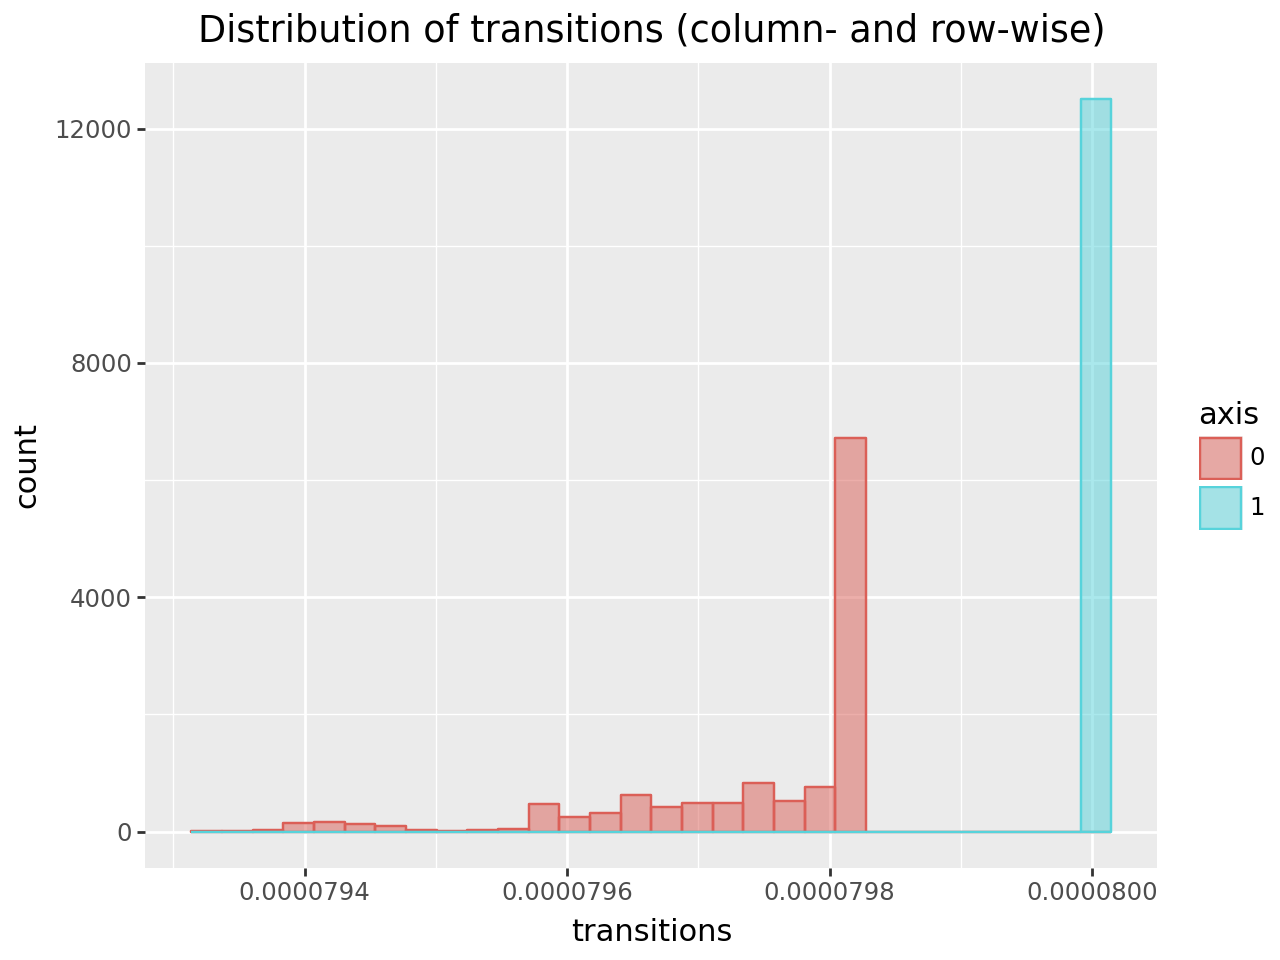

In [12]:
T = transitions[0]
X, Y = np.sum(T, axis = 0), np.sum(T, axis = 1)

df_X = pd.DataFrame(X, columns = ["transitions", ]).assign(axis = '0')
df_Y = pd.DataFrame(Y, columns = ["transitions", ]).assign(axis = '1')
df = pd.concat([df_X, df_Y])  # Combine both into one DataFrame

# Plot density
plot = (
    p9.ggplot(df, p9.aes(x="transitions", color="axis", fill="axis")) +
    p9.geom_histogram(alpha=0.5, bins=30, position="identity")  +# Transparency for overlap
    p9.ggtitle("Distribution of transitions (column- and row-wise)")
)

plot

In [53]:
np.sum(np.sum(T))  # This should sum up to 1

np.float32(0.9999992)

### Get the transitions for each point in the spatial embedding

In [90]:
predictions_T = []
true_T = []
color_by_fraction = []
for i in tqdm(range(fractions)):
    ad_st = adatas_src[i]
    ad_histo = adatas_target[i]
    
    histo_coordinates = ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
    spatial_coordinates = ad_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
    T = transitions[i]
    true_T.append(spatial_coordinates)

    for j in range(ad_st.shape[0]):
        color_by_fraction.append(i)
        t_j = T[j] / np.sum(T[j])
        t_j = np.repeat(t_j[:, None], 3, axis=1)
        prediction = np.sum(histo_coordinates * t_j, axis = 0)
        predictions_T.append(prediction)

predictions_T = np.vstack(predictions_T)
true_T = np.vstack(true_T)

r2_score(true_T, predictions_T)

100%|██████████| 4/4 [00:19<00:00,  4.86s/it]


0.10334821840770214

==> Does work, but poorly

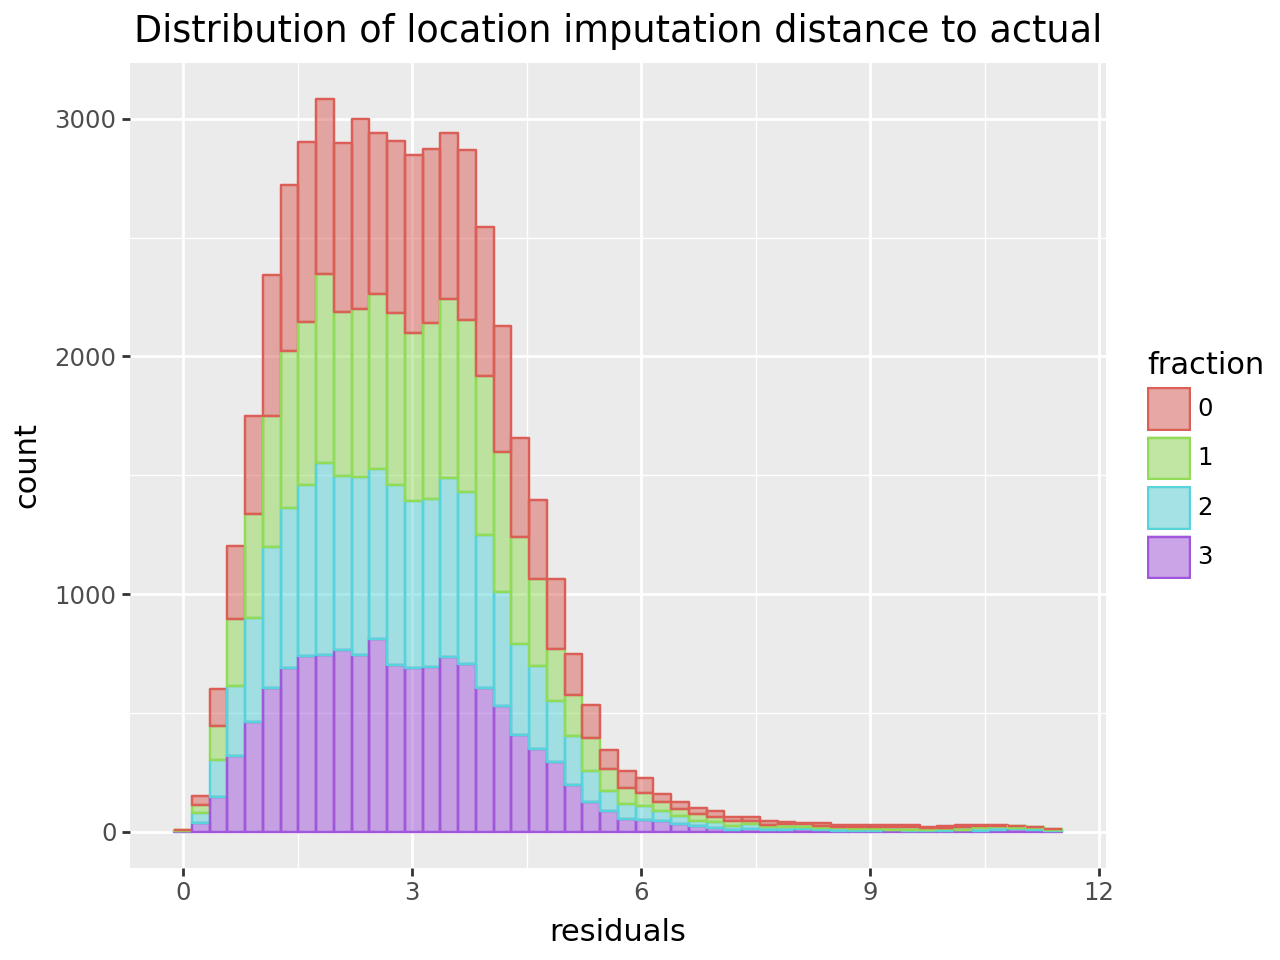

In [56]:
residuals = np.sqrt(np.sum(np.square(true_T - predictions_T), axis = 1))
residuals = pd.DataFrame(residuals, columns = ("residuals",)).assign(
    fraction = pd.Series(color_by_fraction, dtype = str)
)
# Plot density
plot = (
    p9.ggplot(residuals, p9.aes(x="residuals", color="fraction", fill="fraction")) +
    p9.geom_histogram(alpha=0.5, bins=50, position="stack")  +# Transparency for overlap
    p9.ggtitle("Distribution of location imputation distance to actual")
)  

plot

==> Around 3mm away from actual target

#### Use the maximum transition as only 

In [88]:
predictions_max = []
true_max = []
for i in tqdm(range(fractions)):
    ad_st = adatas_src[i]
    ad_histo = adatas_target[i]
    
    histo_coordinates = ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
    spatial_coordinates = ad_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
    T = transitions[i]
    true_max.append(spatial_coordinates)

    for j in range(ad_st.shape[0]):
        ind = np.argmax(T[j])
        prediction = histo_coordinates[ind]
        predictions_max.append(prediction)

predictions_max = np.vstack(predictions_max)
true_max = np.vstack(true_max)

r2_score(true_max, predictions_max)

100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


-0.42332860320757276

==> Works much worse

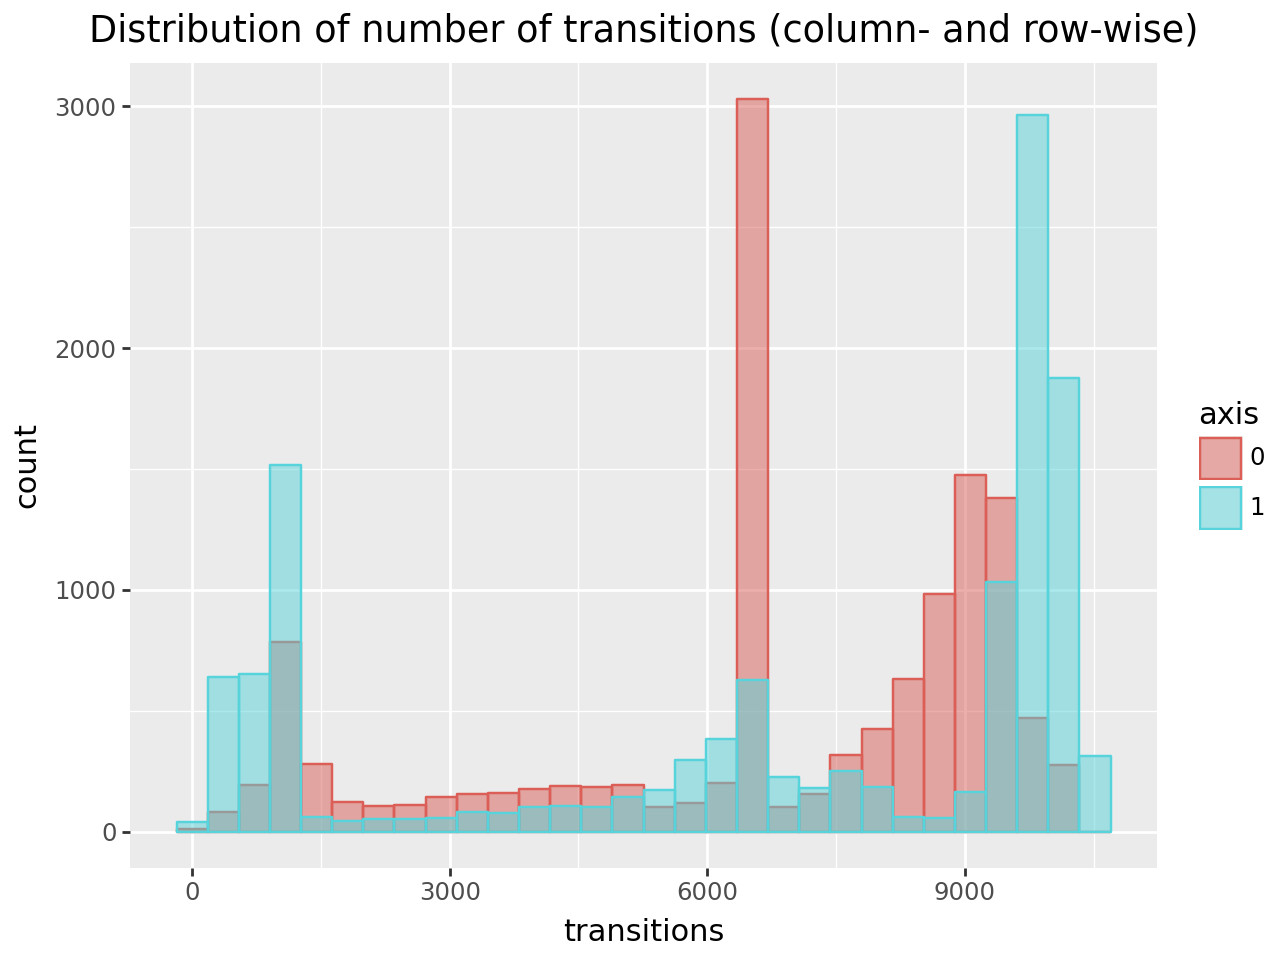

In [18]:
# Look at how much the points are split in a transition
T = transitions[0]
T = T > 0
X, Y = np.sum(T, axis = 0), np.sum(T, axis = 1)

df_X = pd.DataFrame(X, columns = ["transitions", ]).assign(axis = '0')
df_Y = pd.DataFrame(Y, columns = ["transitions", ]).assign(axis = '1')
df = pd.concat([df_X, df_Y])  # Combine both into one DataFrame

# Plot density
plot = (
    p9.ggplot(df, p9.aes(x="transitions", color="axis", fill="axis")) +
    p9.geom_histogram(alpha=0.5, bins=30, position="identity")  +# Transparency for overlap
    p9.ggtitle("Distribution of number of transitions (column- and row-wise)")
)

plot

# Try to account for the fact that spatial slides must all be mapped to one area

/tmp/ipykernel_4162706/3570190692.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


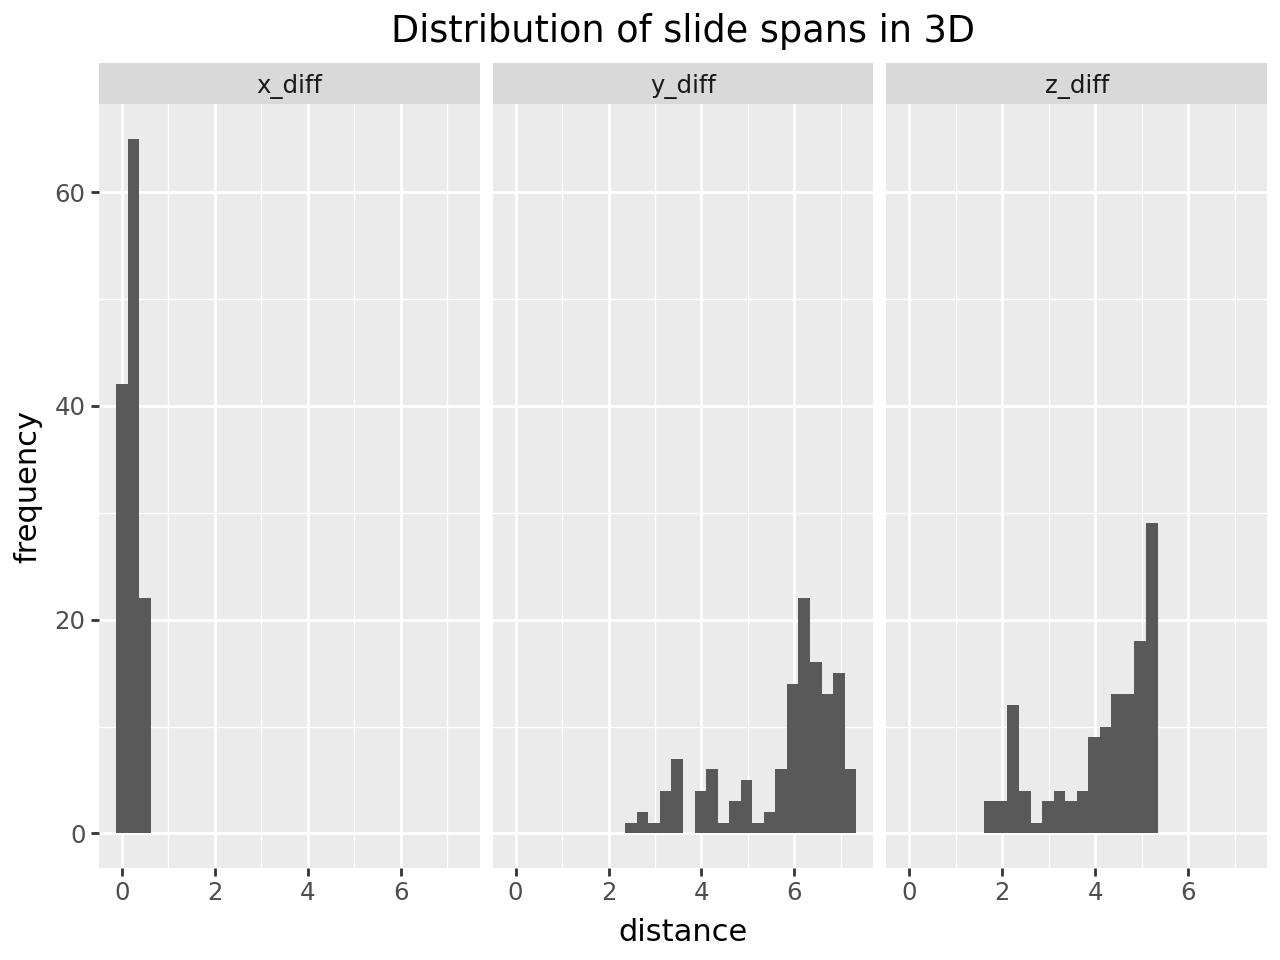

In [74]:
slides = adata_st.obs.assign(residuals = list(residuals.residuals)).groupby("brain_section_label")

perimeters = pd.DataFrame({
    "x_min": slides.x_st.min(),
    "x_max": slides.x_st.max(),
    "y_min": slides.y_st.min(),
    "y_max": slides.y_st.max(),
    "z_min": slides.z_st.min(),
    "z_max": slides.z_st.max()
})
perimeters["x_diff"] = perimeters["x_max"] - perimeters["x_min"]
perimeters["y_diff"] = perimeters["y_max"] - perimeters["y_min"]
perimeters["z_diff"] = perimeters["z_max"] - perimeters["z_min"]
df_plot = pd.melt(perimeters.loc[:, ("x_diff","y_diff","z_diff")])

plot = (
    p9.ggplot(df_plot, p9.aes(x="value")) +
    p9.geom_histogram(bins=30) +
    p9.facet_wrap("~ variable") +
    p9.labs(x = "distance", y= "frequency") +
    p9.ggtitle("Distribution of slide spans in 3D")
)
plot

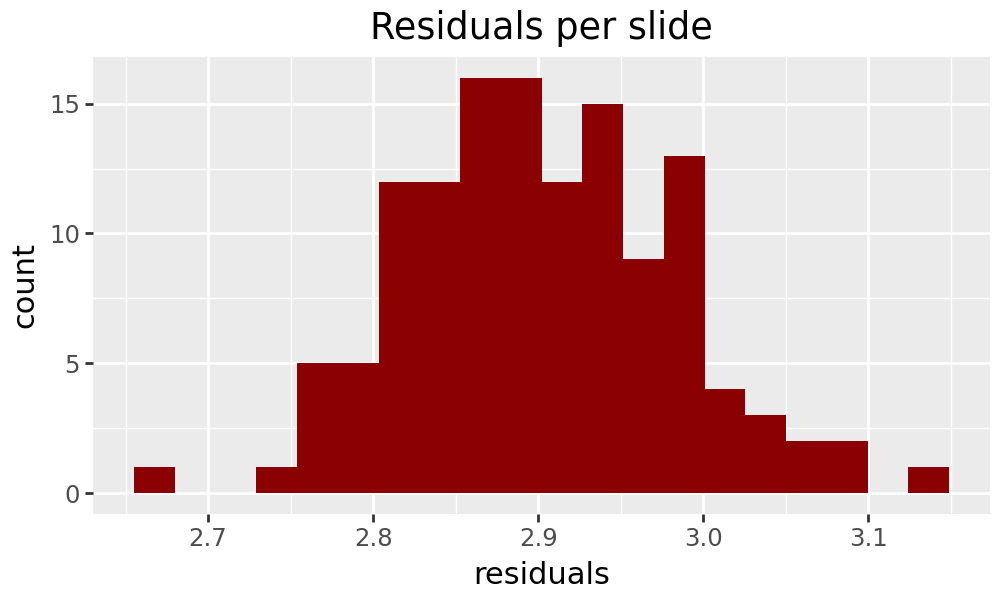

In [119]:
res_per_slide = pd.DataFrame({
     "residuals": slides.residuals.mean()
}).reset_index()

plot = (
    p9.ggplot(res_per_slide, p9.aes(x="residuals")) +
    p9.geom_histogram(bins=20, fill = "darkred") +
    p9.ggtitle("Residuals per slide") +
    p9.theme(figure_size = (5, 3))
)
plot

## First approach: RANSAC regression
RANSAC (RANdom SAmple Consensus) algorithm.

RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set

Let's try it out on 3 slides, one where the predictions worked well, one where they were worst and one average

In [102]:
good_slide = "Zhuang-ABCA-1.114"
avg_slide = "Zhuang-ABCA-1.118"
bad_slide = "Zhuang-ABCA-1.134"
test_slides = (good_slide, avg_slide, bad_slide)
names_slides = ("good_slide", "avg_slide", "bad_slide")

predictions_slides = [predictions_T[adata_st.obs["brain_section_label"] == s, :] for s in test_slides]

In [106]:
# Look at true x
x_slides = [adata_st.obs.loc[adata_st.obs["brain_section_label"] == s, "x_st"].mean() for s in test_slides]
x_slides

[np.float64(10.129272547368423),
 np.float64(10.474512046969696),
 np.float64(11.859390149711539)]

In [101]:
masks = []
counter = 0
for pred in predictions_slides:
    X = pred[:, 1:]  # use the transition matrix predictions
    y = pred[:, 0]  # use the x coordinate as target
    
    reg = RANSACRegressor(random_state = 0)
    reg = RANSACRegressor(random_state=0).fit(X, y)
    
    inlier_mask = reg.inlier_mask_
    filtered_coordinates = pred[inlier_mask]  # Keep only inliers
    masks.append(inlier_mask)
    
    print(f"{test_slides[counter]}: Retained {np.sum(inlier_mask)} points out of {len(pred)}")
    counter += 1

Zhuang-ABCA-1.114: Retained 142 points out of 266
Zhuang-ABCA-1.118: Retained 143 points out of 297
Zhuang-ABCA-1.134: Retained 141 points out of 260


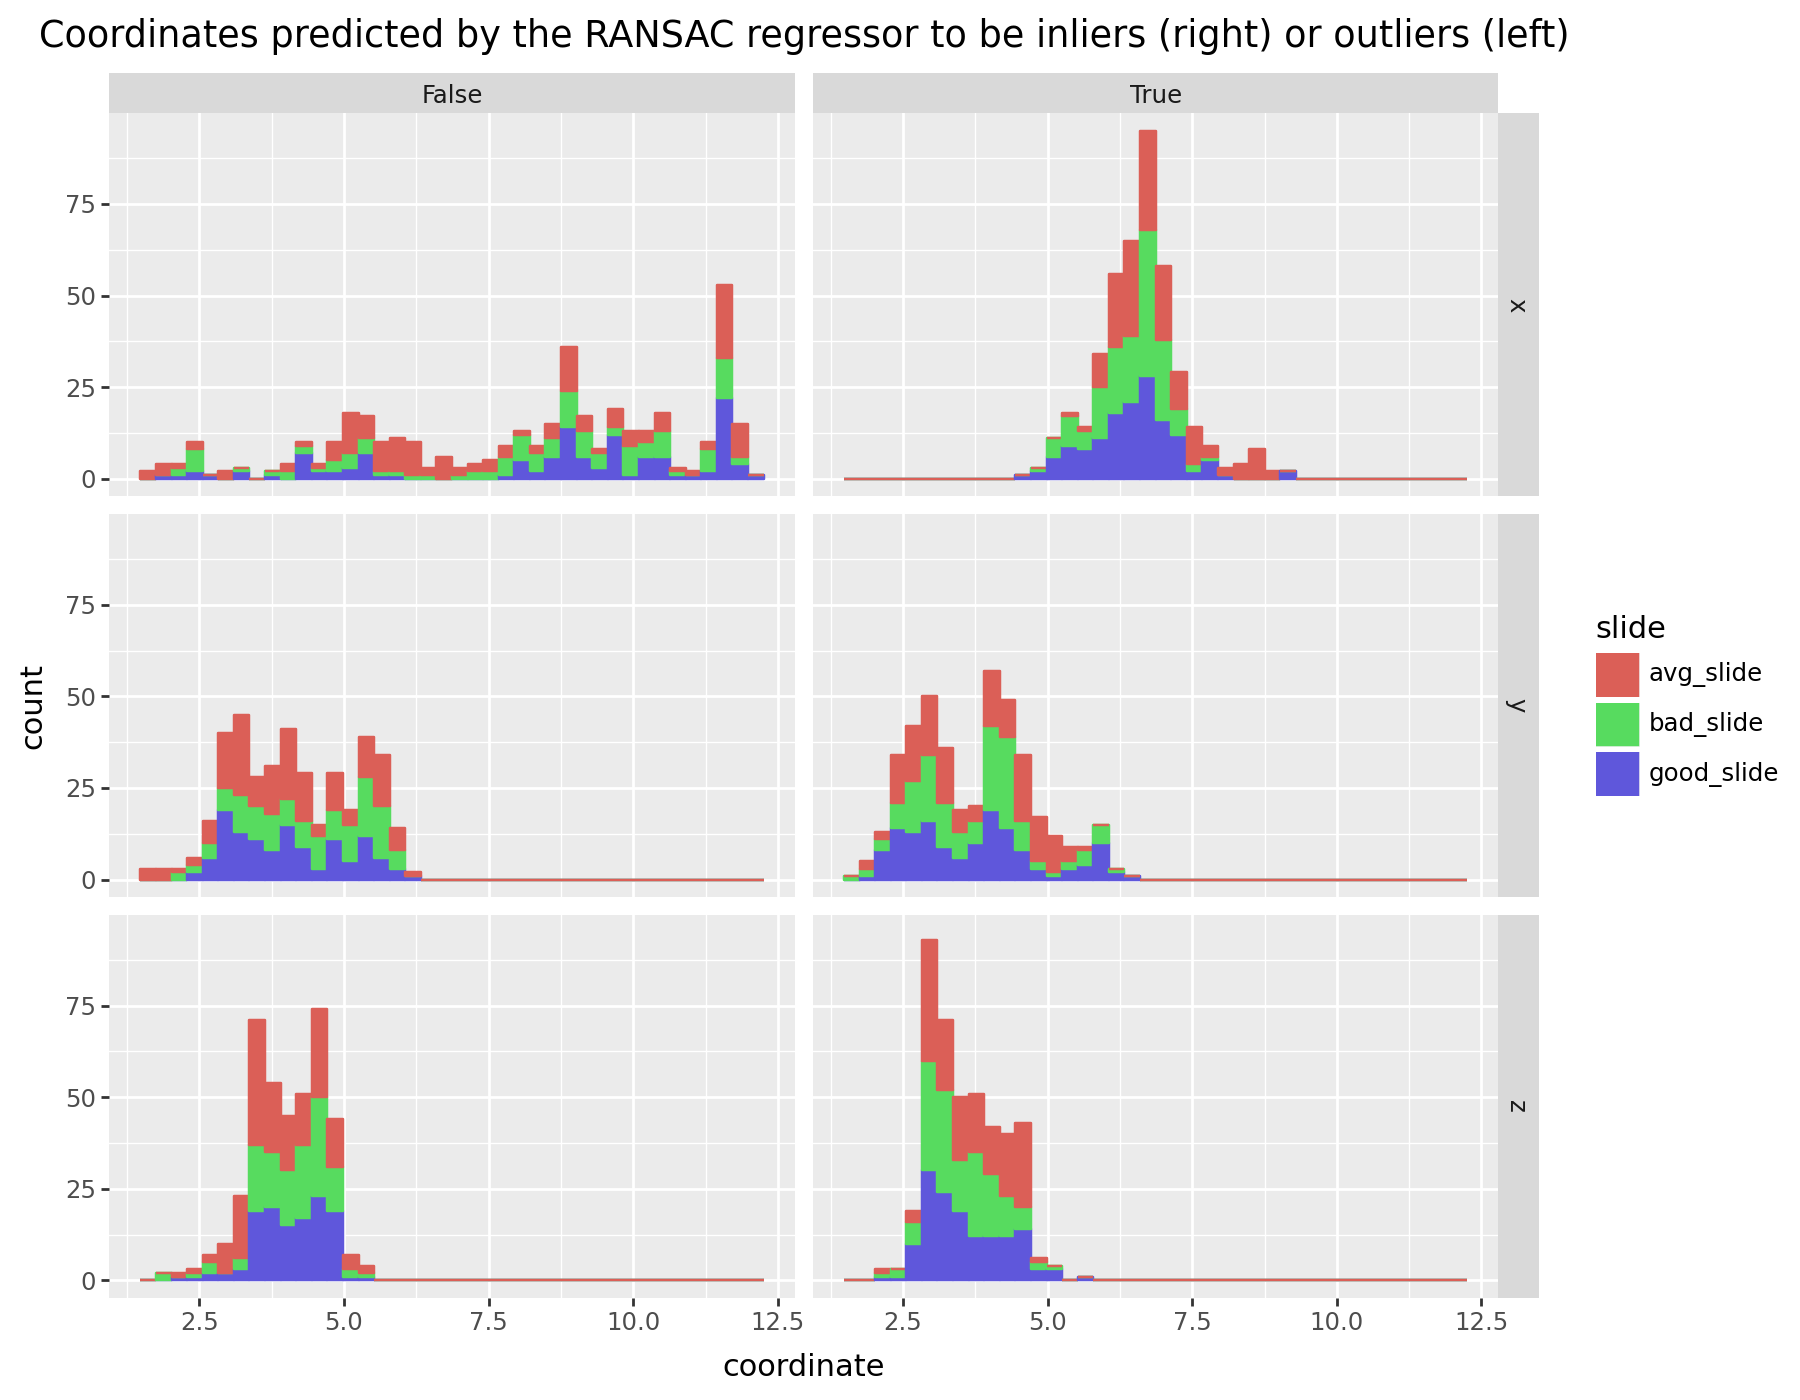

In [109]:
dfs = []
for i in range(3):
    inlier_mask = masks[i]
    pred = predictions_slides[i]
    df_plot = pd.DataFrame(pred, columns = ("x", "y", "z"))
    df_plot["retained"] = "False"
    df_plot.loc[inlier_mask, "retained"] = "True"
    df_plot = df_plot.melt(id_vars = "retained", var_name = "axis", value_name = "coordinate")
    dfs.append(df_plot.assign(slide = names_slides[i]))

df_plot = pd.concat(dfs)

plot = (
    p9.ggplot(df_plot, p9.aes(x="coordinate", fill = "slide", color = "slide"))+
    p9.geom_histogram(bins=40, position = "stack") +
    p9.facet_grid("axis", "retained") +
    p9.ggtitle("Coordinates predicted by the RANSAC regressor to be inliers (right) or outliers (left)") +
    p9.theme(figure_size= (9, 7))
)
plot

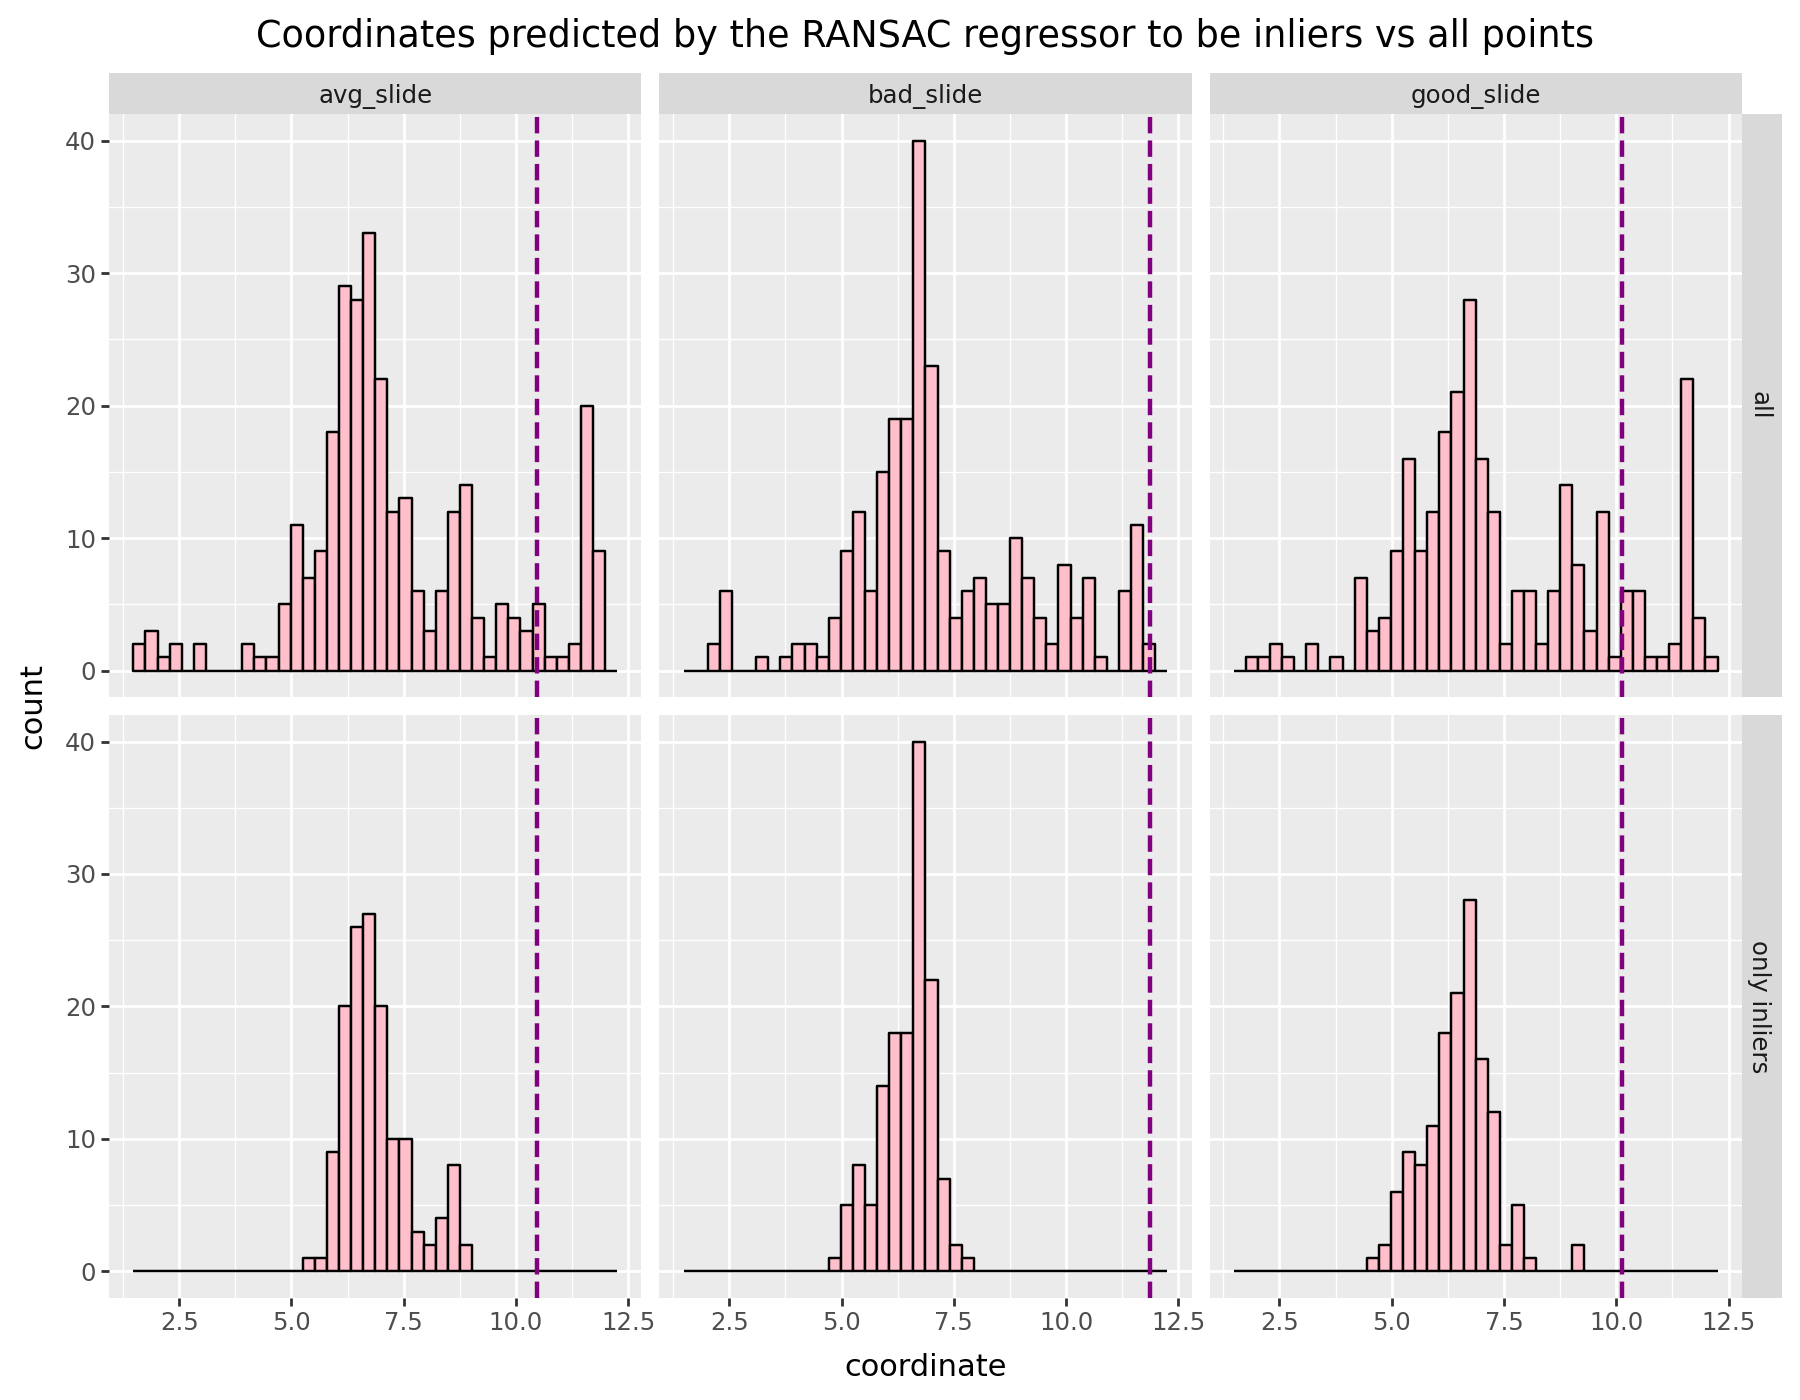

In [117]:
# Plot only x axis
dfs = []
for i in range(3):
    inlier_mask = masks[i]
    pred = predictions_slides[i]
    df = pd.DataFrame(pred[:, 0], columns = ("x",))
    df["RANSAC"] = "all"
    df1 = df.copy()
    df.loc[inlier_mask, "RANSAC"] = "only inliers"
    df2 = df[inlier_mask]
    df = pd.concat((df1, df2), axis=0)
    df_plot = df.melt(id_vars = "RANSAC", var_name = "axis", value_name = "coordinate")
    dfs.append(df_plot.assign(slide = names_slides[i]))

df_plot = pd.concat(dfs)
vlines = pd.DataFrame({
    'slide': names_slides,  # Match facet categories
    'xintercept': x_slides  # Different vertical line for each facet
})

plot = (
    p9.ggplot(df_plot, p9.aes(x="coordinate"))+
    p9.geom_histogram(bins=40, fill = "pink", color = "black") +
    p9.facet_grid("RANSAC", "slide") +
    p9.ggtitle("Coordinates predicted by the RANSAC regressor to be inliers vs all points") +
    p9.geom_vline(p9.aes(xintercept='xintercept'), 
                   data=vlines,  # Use vlines dataset
                   color='purple', linetype='dashed', size = 0.9) +
    p9.theme(figure_size= (9, 7))
)
plot

==> The RANSAC works well, but the original predictions are just very off the actual target, so it is not very helpful (yet) Maybe with better predictions, this could work as well